In [27]:
from dotenv import load_dotenv
load_dotenv()

from typing import Annotated
from typing_extensions import TypedDict

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [28]:
class State(TypedDict):
    message:Annotated[list,add_messages]

In [29]:
@tool
def get_Stock_price(symbol : str)->float:
    """Get the stock price for a given stock symbol (e.g., SENSEX, MSFT, RIL)."""
    return {
        'SENSEX':81000.00,
        'MSFT':750.25,
        'RIL':5820.52
    }.get(symbol,0.0)

tools = [get_Stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [30]:
def chatbot(state:State):
    result = [llm_with_tools.invoke(state["message"])]
    return {"message": result}

builder = StateGraph(State)

builder.add_node('Chatbot_Node',chatbot)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,"Chatbot_Node")
builder.add_conditional_edges("Chatbot_Node",tools_condition)
builder.add_edge("tools", "Chatbot_Node")  # come back after tool execution
graph = builder.compile()

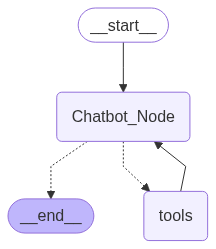

In [31]:
from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
state = graph.invoke({
    "message": [HumanMessage(content="what is the price of SENSEX stock?")]
})
print("Final Assistant Reply:", state["message"][-1].content)

ValueError: No messages found in input state to tool_edge: {'message': [HumanMessage(content='what is the price of SENSEX stock?', additional_kwargs={}, response_metadata={}, id='7123f6f9-1284-4649-b13f-dab3a64528bb'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_Stock_price', 'arguments': '{"symbol": "SENSEX"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--65a7194f-c34c-4a88-8aef-cf27bfa560e7-0', tool_calls=[{'name': 'get_Stock_price', 'args': {'symbol': 'SENSEX'}, 'id': 'f3e74cc6-9bc2-410a-bc49-b11f6172c9f0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 41, 'output_tokens': 8, 'total_tokens': 49, 'input_token_details': {'cache_read': 0}})]}